<a href="https://colab.research.google.com/github/GNuSeekK/Quant/blob/main/%ED%80%80%ED%8A%B8%EA%B8%B0%EB%B0%98_%EC%B6%94%EC%B2%9C%EC%A3%BC_%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DB 테이블 구성

## ktbl


```
create table ktbl (
	kind varchar(4) Not Null,
    k_name varchar(20) Not Null,
    PRIMARY KEY (kind)
);
```
|kind|k_name|
|:--:|:--:|
|50|에너지|
|15|소재|
|...|...|


## comtbl


```
create table comtbl (
	c_code char(6) Not Null,
    c_name varchar(20) Not Null,
    c_kindlarge char(2) Not Null,
    c_kindsmall char(4) Not Null,
    PRIMARY KEY (c_code),
    FOREIGN KEY (c_kindlarge) REFERENCES ktbl (kind),
    FOREIGN KEY (c_kindsmall) REFERENCES ktbl (kind)
);

```
|c_code|c_name|c_kindlarge|c_kindsmall|
|:--:|:--:|:--:|:--:|
|005930|삼성전자|ㅇ|ㅇ|
|005940|뭐시기|ㅇ|ㅇ|
|...|...|...|...|

## ftbl

```
create table ftbl (
	c_code char(6) Not Null,
    f_date DATE Not Null,
    sales BIGINT NOT Null,
    gm BIGINT NOT Null,
    ni BIGINT NOT Null,
    asset BIGINT NOT Null,
    ca BIGINT NOT Null,
    cl BIGINT NOT Null,
    issued_shares BIGINT NOT Null,
    bps INT NOT Null,
    EPS INT NOT Null,
    PRIMARY KEY (c_code, f_date),
    FOREIGN KEY (c_code) REFERENCES comtbl (c_code)
);
```

|c_code|f_date|sales|gm|ni|asset|ca|cl|issued_shares|bps|EPS|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|005930|2020-05-01|15000|8000|4000|30000|16000|8000|500000|385|565|
|...|...|...|...|...|...|...|...|...|...|...|


## prtbl

```
create table prtbl(
	c_code char(6) Not Null,
	p_date DATE Not Null,
    price int not null,
    PRIMARY KEY (c_code, p_date),
    FOREIGN KEY (c_code) REFERENCES comtbl (c_code)
)
```
|c_code|p_date|price|
|:--:|:--:|:--:|
|005930|2020-05-01|15000|
|005930|2020-05-02|15500|
|...|...|...|
|005940|2020-05-01|28700|
|005940|2020-05-02|28500|
|...|...|...|




# Google Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Library import

In [2]:
!pip install pymysql
!pip install cryptography
!pip install colorspacious
 
#드라이브 마운트
import pandas as pd
import numpy as np
import random
import os, sys
import pymysql
import datetime as dt
import requests
from bs4 import BeautifulSoup
import multiprocessing as mp
from multiprocessing import Pool, Manager
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, gridspec
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import warnings
from colorspacious import cspace_converter

     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 3.2 MB 5.0 MB/s 


# Class, Function

## 공유 메모리 관리

In [3]:
num_cores = mp.cpu_count()
manager = Manager()
db_index = manager.list(list(range(num_cores)))
progress = manager.list([0 for x in range(num_cores)])


## Function **db_connecting_aws**

In [4]:
def db_connecting_aws(db_name):
    path = r'/content/gdrive/My Drive/DB 정보/AWS'
    f = open(path)
    id, pw, host = f.read().split()
    db = pymysql.connect(
        user = id,
        port = 3306,
        passwd = pw,
        host = host,
        db = db_name,
        charset = 'utf8',
        cursorclass = pymysql.cursors.DictCursor
    )
    return db

### 실제 DB에 연결하기
* cpu의 갯수만큼 연결한다.
* 하나로 쓸 db, 여러개로 사용할 db_list를 따로 구성한다

In [5]:

#db 작업
 
db = db_connecting_aws('quantdb')

db_list_aws = []
num_cores = mp.cpu_count()
for _ in range(num_cores):
    db_list_aws.append(db_connecting_aws('quantdb'))


## Function insert_replace
* 매개변수(parameter) : db, df, tbl
    > db를 이용하여 df(데이터프레임)을 tbl(테이블)에 replace insert 한다.

In [6]:
#데이터 넣기, 입력값 // db = 데이터베이스, df = 데이터프레임
def insert_replace(db,df,tbl,foreign_key_checks = False):
    if foreign_key_checks:
        with db.cursor() as cursor:
            cursor.execute('SET foreign_key_checks=0')
    df_list = df.values.tolist()
    slicing = 5000
    rep = int(len(df_list)/slicing) + 1 #반복횟수
    for num in range(rep):
        if num != (rep-1):
            df_sql = df_list[num*slicing:(num+1)*slicing]
        else:
            df_sql = df_list[num*slicing:]
        sql_list = []
        for value in df_sql:
            tmp = '(' + ', '.join(value) + ')'
            sql_list.append(tmp)
    
        sql = 'replace into %s values ' %tbl + ', '.join(sql_list)
        with db.cursor() as cursor:
            cursor.execute(sql)
    if foreign_key_checks:
        with db.cursor() as cursor:
            cursor.execute('SET foreign_key_checks=1')
    db.commit()

## Function insert_ignore
* 매개변수(parameter) : db, df, tbl
    > db를 이용하여 df(데이터프레임)을 tbl(테이블)에 ignore insert 한다.

In [7]:
#데이터 넣기, 입력값 // db = 데이터베이스, df = 데이터프레임
def insert_ignore(db,df,tbl,foreign_key_checks = False):
    if foreign_key_checks:
        with db.cursor() as cursor:
            cursor.execute('SET foreign_key_checks=0')
    df_list = df.values.tolist()
    slicing = 5000
    rep = int(len(df_list)/slicing) + 1 #반복횟수
    for num in range(rep):
        if num != (rep-1):
            df_sql = df_list[num*slicing:(num+1)*slicing]
        else:
            df_sql = df_list[num*slicing:]
        sql_list = []
        for value in df_sql:
            tmp = '(' + ', '.join(value) + ')'
            sql_list.append(tmp)
    
        sql = 'insert ignore into %s values ' %tbl + ', '.join(sql_list)
        with db.cursor() as cursor:
            cursor.execute(sql)
    if foreign_key_checks:
        with db.cursor() as cursor:
            cursor.execute('SET foreign_key_checks=1')
    db.commit()

## Function **my_pbar**
* 매개변수(parameter) : value, endvalue, bar_length(default = 20)

In [8]:
def my_pbar(value, endvalue, bar_length = 20):
    percent = float(value) / endvalue
    if percent <= 0.33:
        color = 91
    elif percent <= 0.66:
        color = 93
    elif percent == 1:
        color = 92
    else:
        color = 96
    complete = '<' + '▮' * int(round(percent * bar_length))
    remain = '▯' * (bar_length - (len(complete) - 1)) + '>'
    sys.stdout.write(f"\r\033[{color}m Percent: [{complete+remain}] {round(percent*100,2)}%\033[0m")
    sys.stdout.flush()

## Function ftbl_input
* 매개변수(parameter) : code
    > 종목코드가 code인 주식의 Financial Data를 ftbl에 넣는다.
    
    > insert_data를 내부적으로 사용한다.

In [9]:
def ftbl_input(code):
    tmp_index = db_index.pop(0)
    db = db_list_aws[tmp_index]
    try:
        invest_url = 'https://comp.fnguide.com/SVO2/ASP/SVD_Invest.asp?pGB=1&gicode=A%s&cID=&MenuYn=Y&ReportGB=&NewMenuID=105&stkGb=701' %code
        invest_page = requests.get(invest_url)
        fs_url = 'https://comp.fnguide.com/SVO2/ASP/SVD_Finance.asp?pGB=1&gicode=A%s&cID=&MenuYn=Y&ReportGB=&NewMenuID=103&stkGb=701' %code
        fs_page = requests.get(fs_url)
        soup = BeautifulSoup(invest_page.text, "html.parser")
        #수정평균주식수
        stock = soup.find_all('tr', class_= 'c_grid1_1 rwf acd_dep2_sub')
        issued_shares = [x.text for x in stock if '주식수' in x.text]#크롤링 데이터
        index = str(issued_shares).find('수정')
        issued_shares = str(issued_shares)[index:]
        issued_shares = issued_shares.replace('\\n', ' ')
        issued_shares = issued_shares.replace('\\xa0', '0')
        issued_shares = issued_shares.replace(',', '')
        issued_shares = issued_shares.split(' ')[:6]
        #날짜, EPS, BPS
        invest_df = pd.read_html(invest_page.text, index_col = 0)[1]
        fs_df = pd.read_html(fs_page.text, index_col = 0)
        acc_month = invest_df.columns.tolist()[-2].split('/')[1] #account month 결산월
        df = []
        for year in range(2018,2021):
            column = [x for x in invest_df.columns.tolist() if f'{year}/{acc_month}' in x]
            if len(column) > 0:
                # 회사코드 append
                text_list = []
                text_list.append("'" + code + "'") 
                # column 설정
                column = column[0]
                # f_date append
                f_date = dt.datetime(year,int(acc_month),1) + relativedelta(months=5)
                f_date = f"'{str(f_date)[:10]}'"
                text_list.append(f_date) 
                # sales append (매출액)
                sales = str(fs_df[0][column]['매출액']).split('.')[0]
                text_list.append(sales)
                # gm append (매출총이익)
                gm = str(fs_df[0][column]['매출총이익']).split('.')[0]
                text_list.append(gm)
                # ni append (당기순이익)
                ni = str(fs_df[0][column]['당기순이익']).split('.')[0]
                text_list.append(ni)
                # asset append (자산)
                asset = str(fs_df[2][column]['자산']).split('.')[0]
                text_list.append(asset)
                # ca append (유동자산)
                index = [x for x in fs_df[2].index.tolist() if '유동자산' in x][0]
                ca = str(fs_df[2][column][index]).split('.')[0]
                text_list.append(ca)
                # cl append (유동부채)
                index = [x for x in fs_df[2].index.tolist() if '유동부채' in x][0]
                cl = str(fs_df[2][column][index]).split('.')[0]
                text_list.append(cl)
                # issued_shares append
                index = invest_df.columns.tolist().index(column)
                text_list.append(str(issued_shares[index+1]))
                # bps append
                index = [x for x in invest_df.index.tolist() if 'BPS계산' in x][0]
                bps = invest_df[column][index] 
                text_list.append(str(bps)) 
                # eps append
                index = [x for x in invest_df.index.tolist() if 'EPS계산' in x][0]
                eps = invest_df[column][index]
                text_list.append(str(eps))
                if np.nan not in text_list:
                    df.append(text_list)
                else:
                    print(f'Error Code : You have Null Data in {code}')
        df = pd.DataFrame(df)
        insert_replace(db,df,'ftbl',foreign_key_checks = True)
    except:
        return code
    finally:
        progress[tmp_index] = progress[tmp_index] + 1
        db_index.append(tmp_index)
        my_pbar(sum(progress),len_code.value)
        pass

## Function prtbl_input
* 매개변수(parameter) : code, timeframe, count
    > code, timeframe, count를 이용해 가격 데이터를 수집한다.<br\> timeframe과 count는 default 값이 있다.
    
    > insert_ignore를 내부적으로 사용한다.

In [10]:
def prtbl_input(code, timeframe = 'day', count = '1000'):
    tmp_index = db_index.pop(0)
    db = db_list_aws[tmp_index]
    try:
        url = 'https://fchart.stock.naver.com/sise.nhn?requestType=0'
        price_url = url + '&symbol=' + code + '&timeframe=' + timeframe + '&count=' + count
        price_data = requests.get(price_url)
        price_data_bs = BeautifulSoup(price_data.text, 'lxml')
        item_list = price_data_bs.find_all('item')


        date_list = []
        price_list = []

        for item in item_list:
            temp_data = item['data']
            datas = temp_data.split('|') # 날짜, 시가, 고가, 저가, 종가, 거래량
            date_list.append("'" + datas[0][:4] + "-" + datas[0][4:6] + "-" + datas[0][6:] + "'")
            price_list.append(datas[4])

        code_list = [f"'{code}'"] * len(date_list)
        price_df = pd.DataFrame(
                    {
                    'code' : code_list,
                    'date' : date_list,
                    'price' : price_list
                    }
                )
        insert_ignore(db,price_df,'prtbl')
    except: 
        return code
    finally:
        progress[tmp_index] = progress[tmp_index] + 1
        db_index.append(tmp_index)
        my_pbar(sum(progress),len_code.value)
        pass

## Function custom_colorbargraph

https://jehyunlee.github.io/2020/08/10/Python-DS-25-custom_colormap_code/

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


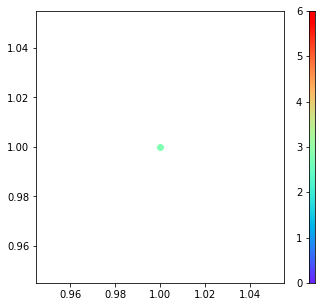

In [140]:
def custom_colorbargraph(min_color, max_color):
    fig = plt.figure(figsize=(5, 5)) 
    gs = gridspec.GridSpec(nrows=1, # row 몇 개 
                        ncols=2, # col 몇 개 
                        height_ratios=[20], 
                        width_ratios=[20, 0.5]
                        )


    color_x = [0] * 256
    color_y = np.linspace(min_color, max_color, 256)

    cmap = 'rainbow'  # 표현할 컬러맵 

    ax1 = plt.subplot(gs[1])
    ax1.scatter(color_x, color_y, c=color_y, cmap=cmap, s=520)
    plt.ylim(min_color,max_color)
    plt.xticks([])

    ax0 = plt.subplot(gs[0])

    return ax0

def color_find(min_color, max_color, x):

    x = int(((x - min_color) / (max_color - min_color)) * 256)
    cmap = 'rainbow'
    rgb = cm.get_cmap(cmap)(x)

    return rgb

## Class API

In [11]:
# execute_list 의 경우 이후 다른 자료구조로 변경 예정

class API:
    def __init__(self, key, limit):
        self.key = key
        self.limit = limit  # (갯수 , time) 튜플로 구성된 것
        self.execute_list = []

    def time_append(self):
        time = dt.datetime.now()
        if len(self.execute_list) == self.limit[0] - 1:
            self.execute_list.pop(0)
        self.execute_list.append(time)

    def sleep(self):
        time = dt.datetime.now()
        if len(self.execute_list) == self.limit[0] - 1:
            wait_time = self.limit[1] - (dt.datetime.now() - time)
        if wait_time > 0:
            time.sleep(self.limit[1] - wait_time)


### API Class 만들기

In [12]:
path = r'/content/gdrive/My Drive/DB 정보/DartAPI'
with open(path) as f:
    key = f.read()

api = API(key, (100,60))

## WICS(국제산업표준)

In [13]:
wics_lc = {10:'에너지', 
           15:'소재', 
           20:'산업재', 
           25:'경기관련소비재', 
           30:'필수소비재', 
           35:'건강관리',
           40:'금융', 
           45:'IT', 
           50:'커뮤니케이션서비스', 
           55:'유틸리티'}
 
wics_mc = {1010:'에너지',
           1510:'소재',
           2010:'자본재',
           2020:'상업서비스와공급품',
           2030:'운송',
           2510:'자동차와부품',
           2520:'내구소비재와의류',
           2530:'호텔,레스토랑,레저 등',
           2550:'소매(유통)',
           2560:'교육서비스',
           3010:'식품과기본식료품소매',
           3020:'식품,음료,담배',
           3030:'가정용품과개인용품',
           3510:'건강관리장비와서비스',
           3520:'제약과생물공학',
           4010:'은행',
           4020:'증권',
           4030:'다각화된금융',
           4040:'보험',
           4050:'부동산',
           4510:'소프트웨어와서비스',
           4520:'기술하드웨어와장비',
           4530:'반도체와반도체장비',
           4535:'전자와 전기제품',
           4540:'디스플레이',
           5010:'전기통신서비스',
           5020:'미디어와엔터테인먼트',
           5510:'유틸리티'}
 
def wics_url(date, wics_code):
    url =f'http://www.wiseindex.com/Index/GetIndexComponets?ceil_yn=0&dt={date}&sec_cd=G{wics_code}'
    return url

In [14]:
pd.read_sql('select * from comtbl limit 100',db)

,c_code,c_name,c_kindlarge,c_kindsmall
0,000020,동화약품,35,3520
1,000040,KR모터스,25,2510
2,000050,경방,25,2520
3,000060,메리츠화재,40,4040
4,000070,삼양홀딩스,30,3020
...,...,...,...,...
95,001940,KISCO홀딩스,15,1510
96,002020,코오롱,15,1510
97,002030,아세아,15,1510
98,002070,비비안,25,2520


# ktbl 입력

In [ ]:
df = pd.concat([pd.DataFrame(wics_lc.items()), pd.DataFrame(wics_mc.items())])
df = df.astype('str')
df = "'" + df + "'"

insert_replace(db,df,'ktbl',foreign_key_checks = True)
db.commit()

# comtbl 입력

In [ ]:
df = pd.DataFrame(columns=['code', 'name', 'ls', 'ms'])
date = str(dt.date.today() - dt.timedelta(days = 1)).replace('-','')
# there is no data in the stock market closed day and before market open. 
# weekends, Jan 1, Dec 31 etc

for wics_code in wics_mc.keys():
    response = requests.get(wics_url(date, wics_code))

    if response.status_code == 200: # request success
        json_list = response.json() # dictionary
        # response.text -> return str type
        for json in json_list['list']:
            ls = json['SEC_CD'][-2:] # Large sector
            ms = json['IDX_CD'][-4:] # Medium sector
            code = json['CMP_CD'] # Company code
            name = json['CMP_KOR'] # Company korean name
            df = df.append({'code':code, 'name':name, 'ls':ls, 'ms':ms}, 
                    ignore_index=True)
    else:
        print('Error:' + response.status_code)
        print('WICS code:' + str(wics_code))

df = "'" + df + "'"

insert_replace(db,df,'comtbl',foreign_key_checks = True)

db.commit()

# ftbl 입력

In [ ]:
code_list = pd.read_sql('select c_code from comtbl',db)['c_code'].tolist()
len_code = manager.Value(int, len(code_list))
pool = Pool(num_cores) # process 만들기
 
start_time = dt.datetime.now()
error_code = list(pool.map(ftbl_input, code_list))
error_code = [x for x in error_code if x != None]
my_pbar(100,100)
progress = manager.list([0 for x in range(num_cores)])
print('총 걸린시간 : %s' %(dt.datetime.now() - start_time))
print(f'에러 갯수 : {len(error_code)}')
pool.close()
pool.join()

 Percent: [<▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮>] 100.0%총 걸린시간 : 0:03:05.382549
에러 갯수 : 159


# prtbl 입력

In [ ]:
code_list = pd.read_sql('select distinct c_code from ftbl',db)['c_code'].tolist()
len_code = manager.Value(int, len(code_list))
pool = Pool(num_cores) # process 만들기
 
start_time = dt.datetime.now()
erorr_code = list(pool.map(prtbl_input, code_list))
error_code = [x for x in error_code if x != None]
my_pbar(100,100)
progress = manager.list([0 for x in range(num_cores)])
print(f'총 걸린시간 : {dt.datetime.now() - start_time}')
print(f'에러 갯수 : {len(error_code)}')
pool.close()
pool.join()

 Percent: [<▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮>] 100.0%총 걸린시간 : 0:01:17.119118
에러 갯수 : 159


# 기업 날짜별 데이터 구하기

## Score 추출

In [15]:
date = '2020-05-01'
sql = f"""
with f_rank_cte as
(select c_code, f_date, sales, gm, ni, asset, ca, cl, issued_shares, bps, eps,
    RANK() OVER ( 
        partition by c_code 
        order by f_date desc) Ranking
    from ftbl 
    where f_date <= '{date}'
            ),

k_code_cte as
(select
    c_code,
    concat(c_kindlarge,c_kindsmall) as k_code
    from comtbl
),

f_score_cte as
(select
    first_year_cte.c_code as c_code,
    first_year_cte.sales / second_year_cte.sales - 1 as sales_growth,
    first_year_cte.gm / first_year_cte.sales as gm_ratio,
    first_year_cte.ca / first_year_cte.cl as current,
    first_year_cte.ni / ( ( first_year_cte.asset + second_year_cte.asset ) / 2 ) as roa,
    first_year_cte.sales / ( ( first_year_cte.asset + second_year_cte.asset ) / 2 ) as inventory_turnover,
    k_code_cte.k_code as k_code
    from
        (select * from f_rank_cte where Ranking = 1) as first_year_cte,
        (select * from f_rank_cte where Ranking = 2) as second_year_cte,
        (select * from k_code_cte) as k_code_cte
    where
        first_year_cte.c_code = second_year_cte.c_code and
        first_year_cte.c_code = k_code_cte.c_code
)

select * from f_score_cte
"""
graph_df = pd.read_sql(sql,db)
# null 값 제거
graph_df = graph_df.dropna(axis=0)
# 이상치 데이터 제거
graph_df = graph_df[graph_df['sales_growth'] < 10]

### 분포 확인

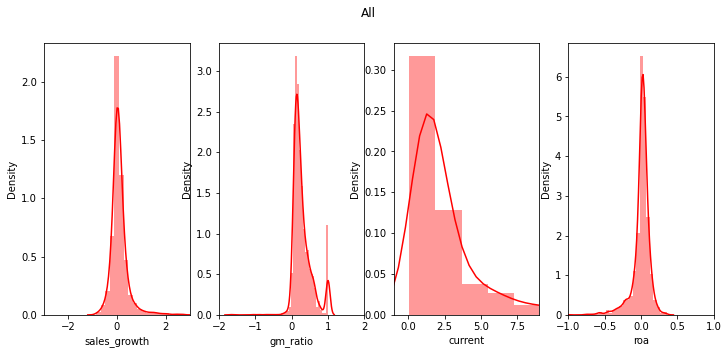

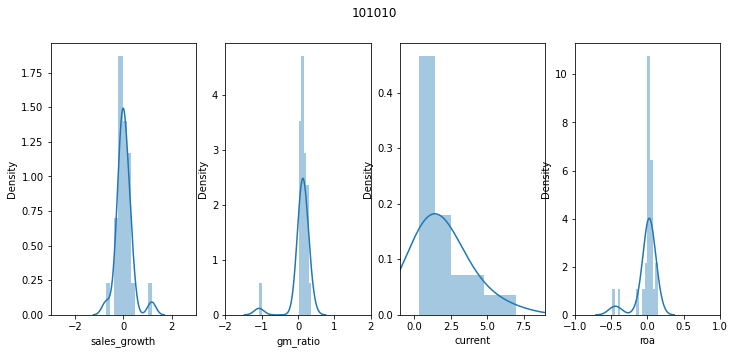

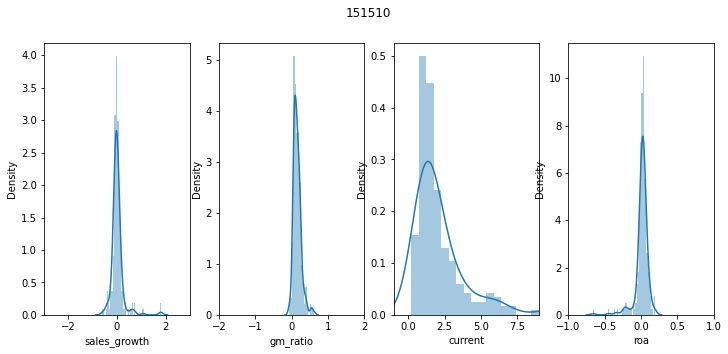

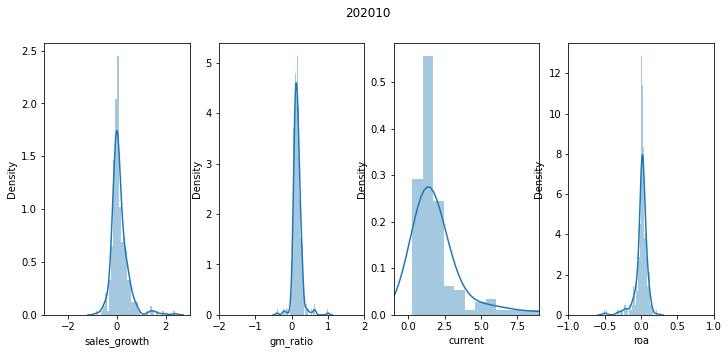

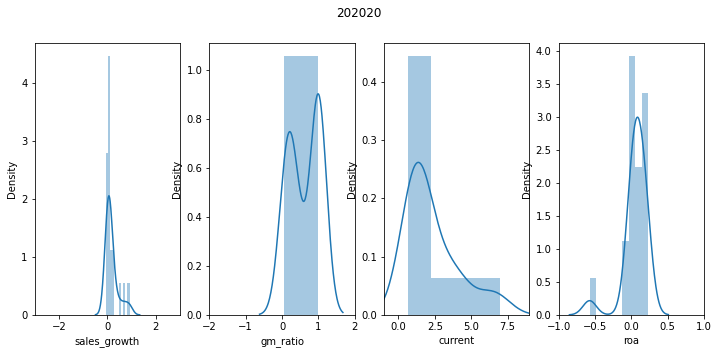

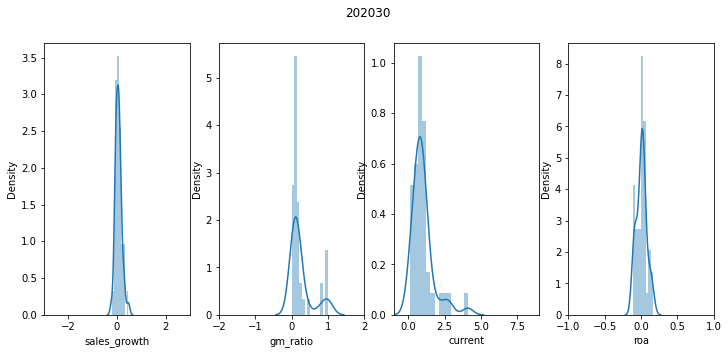

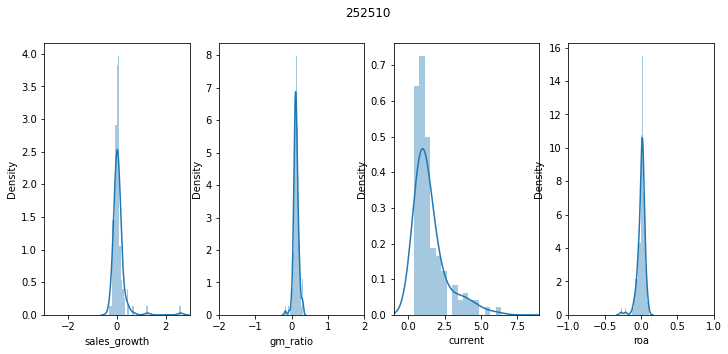

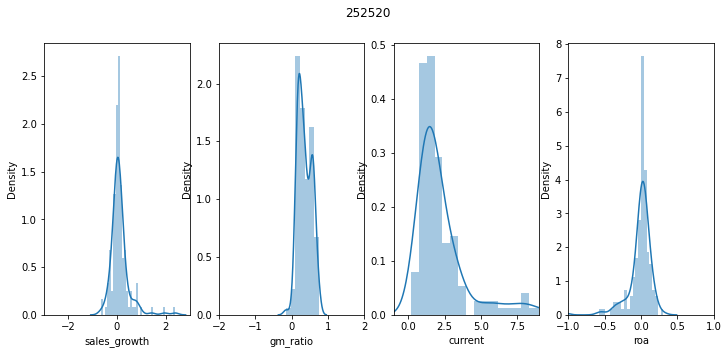

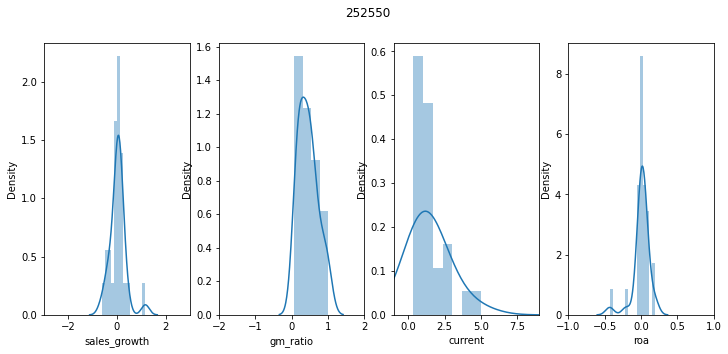

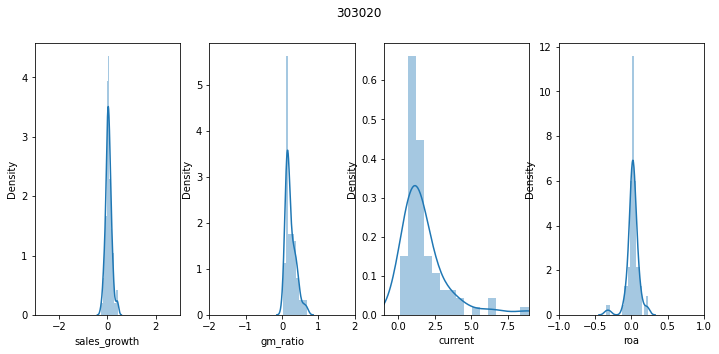

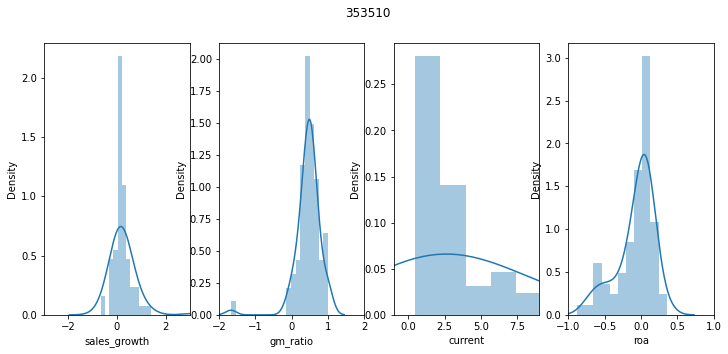

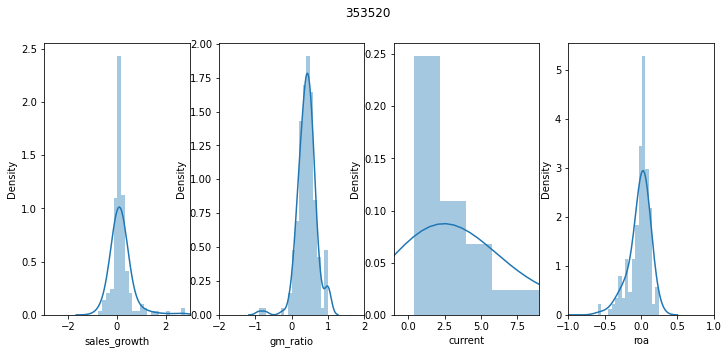

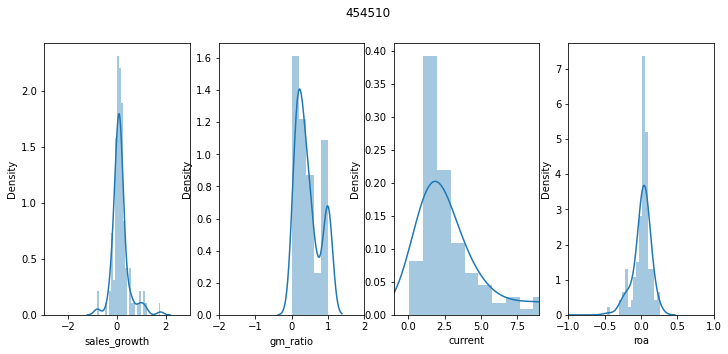

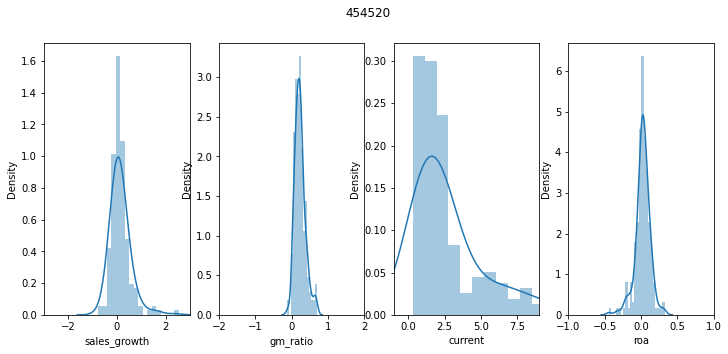

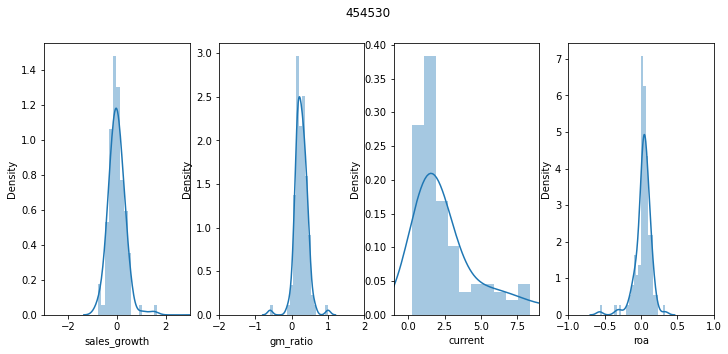

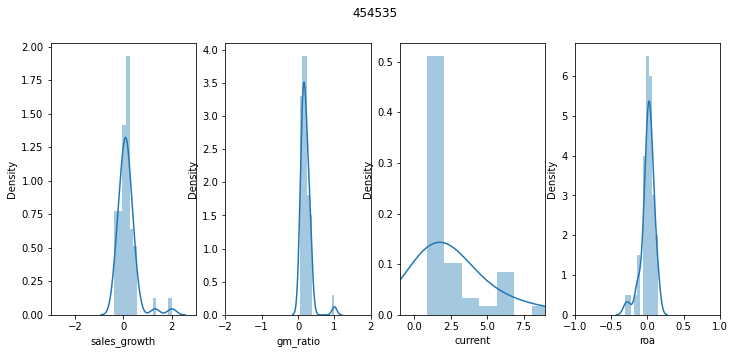

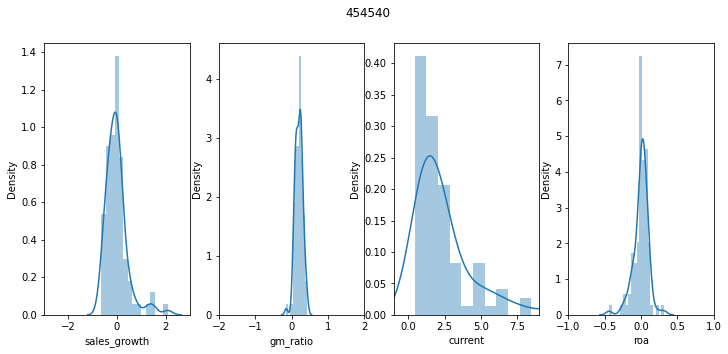

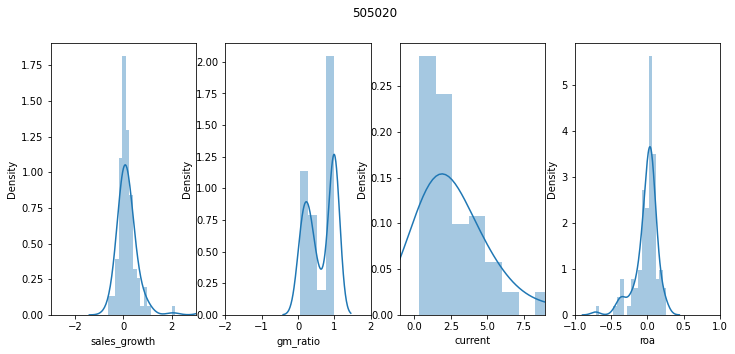

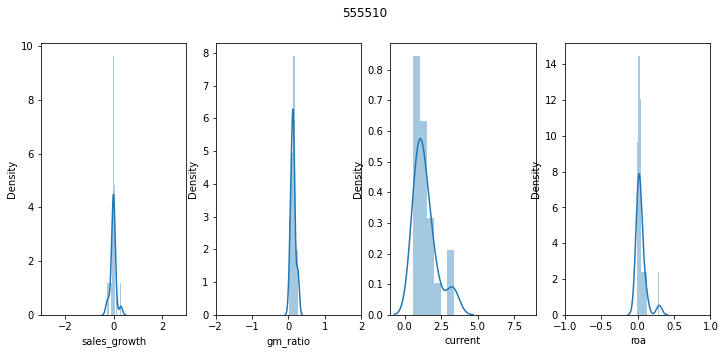

In [ ]:
warnings.filterwarnings(action='ignore') 

# 전체 데이터의 분포

plt.figure(figsize=(12,5))
plt.suptitle('All')
plt.subplot(111)
graph = graph_df
plt.subplot(141)
sns.distplot(graph['sales_growth'], color = 'red')
plt.xlim(-3,3)
plt.subplot(142)
sns.distplot(graph['gm_ratio'], color = 'red')
plt.xlim(-2,2)
plt.subplot(143)
sns.distplot(graph['current'], color = 'red')
plt.xlim(-1,9)
plt.subplot(144)
sns.distplot(graph['roa'], color = 'red')
plt.xlim(-1,1)
plt.show()
print('')

# k_code 별로 sales_growth, gm_ratio, current, roa의 분포도를 보고 싶다.
# 단 k_code안에 20개 이상의 데이터가 존재해야 한다.
tmp = graph_df.groupby(['k_code']).count()
tmp = tmp[tmp['c_code'] >= 20]
k_codes = tmp.index.tolist()

for k_code in k_codes:
    plt.figure(figsize=(12,5))
    plt.suptitle(f'{k_code}')
    plt.subplot(111)
    graph = graph_df[graph_df['k_code'] == k_code]
    plt.subplot(141)
    sns.distplot(graph['sales_growth'])
    plt.xlim(-3,3)
    plt.subplot(142)
    sns.distplot(graph['gm_ratio'])
    plt.xlim(-2,2)
    plt.subplot(143)
    sns.distplot(graph['current'])
    plt.xlim(-1,9)
    plt.subplot(144)
    sns.distplot(graph['roa'])
    plt.xlim(-1,1)
    plt.show()

warnings.filterwarnings(action='default')

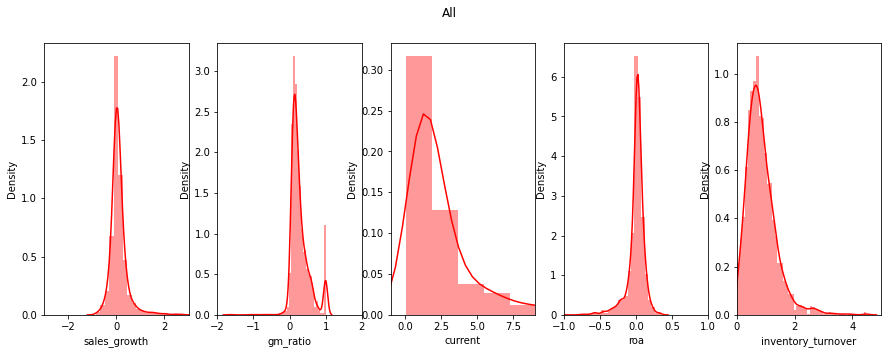

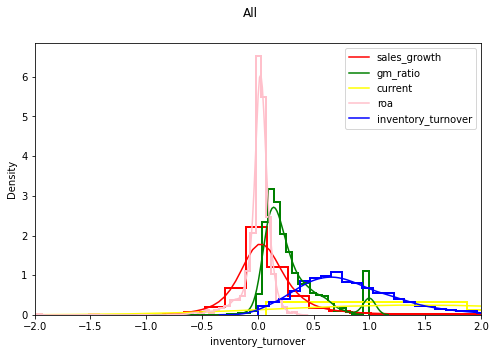

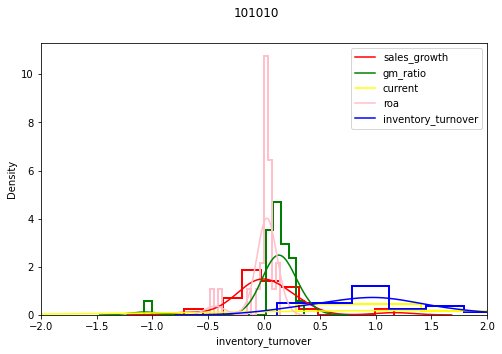

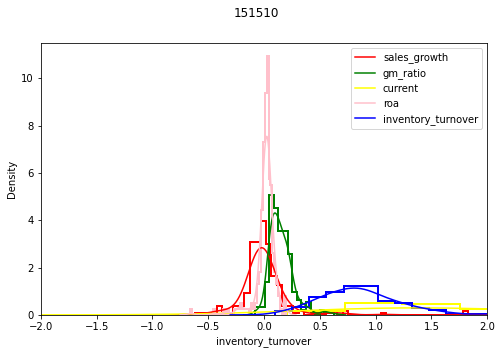

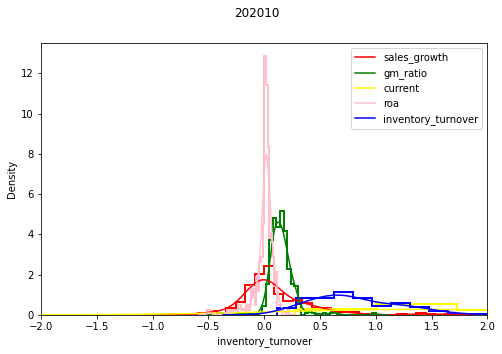

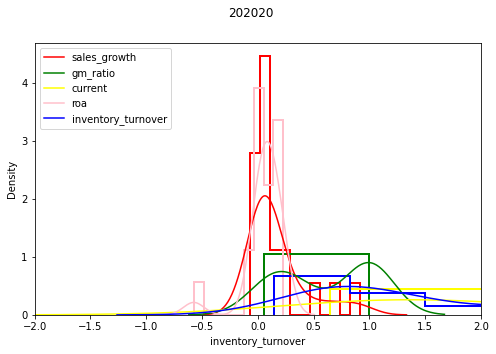

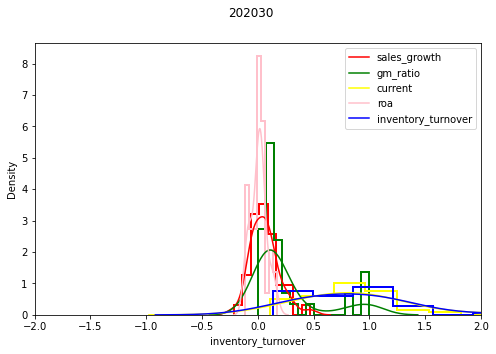

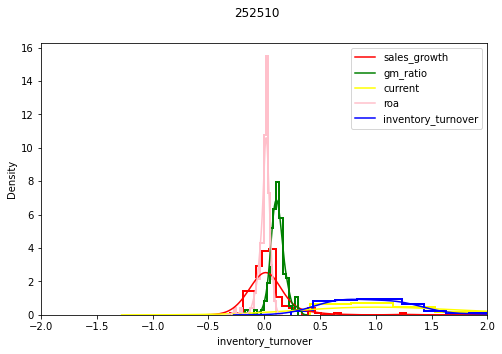

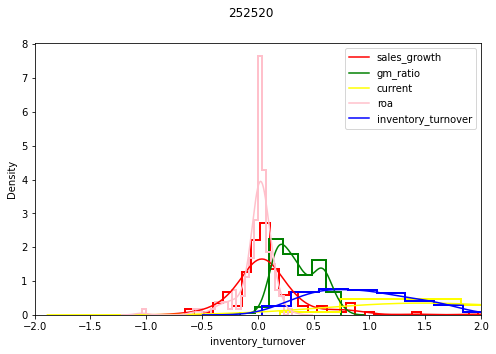

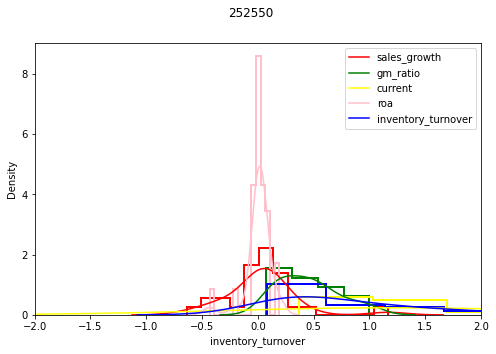

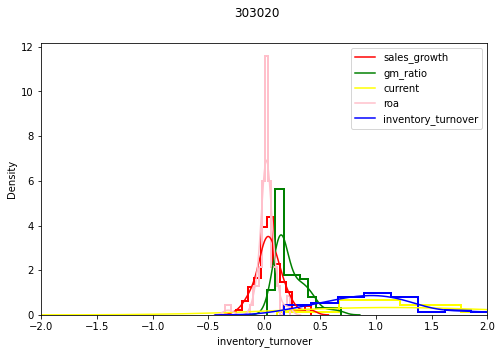

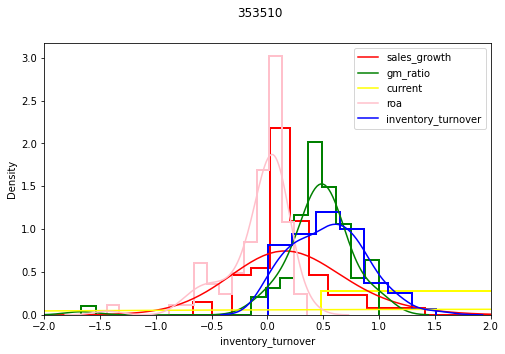

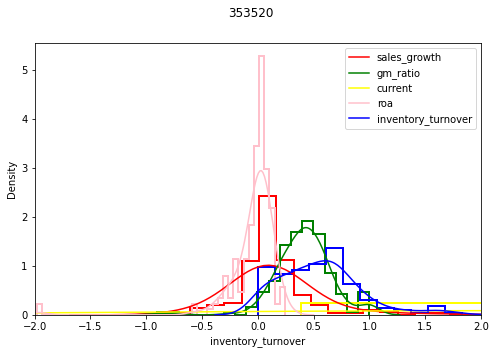

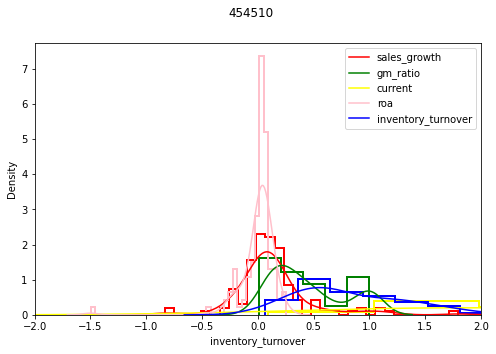

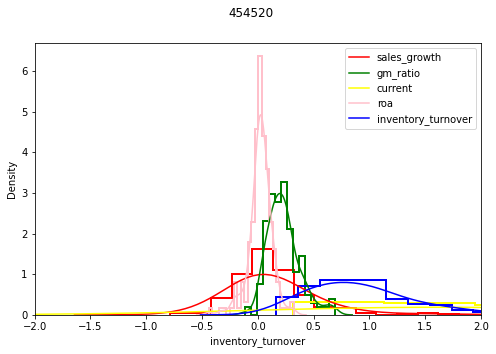

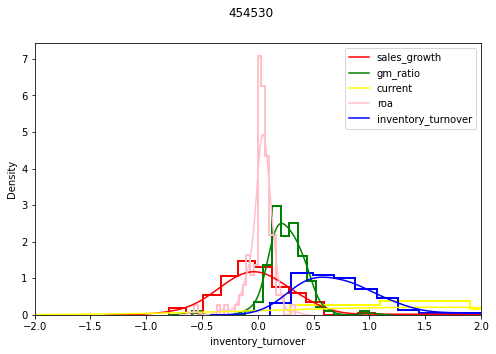

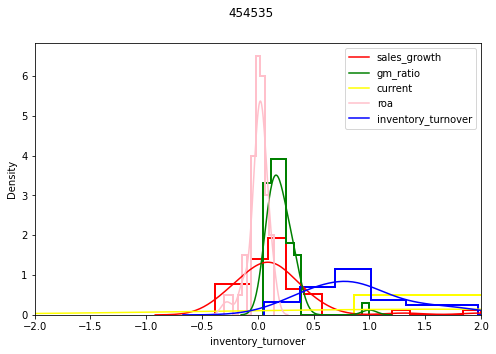

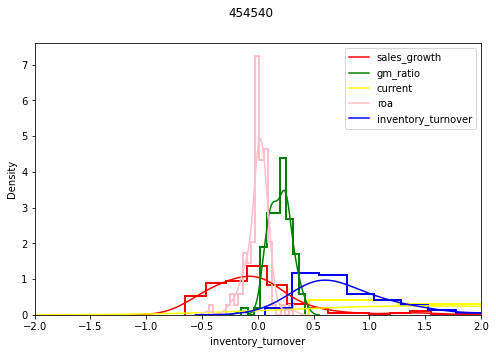

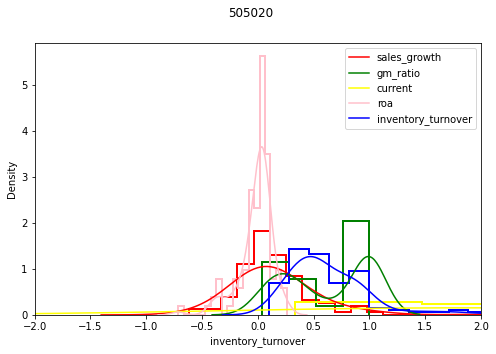

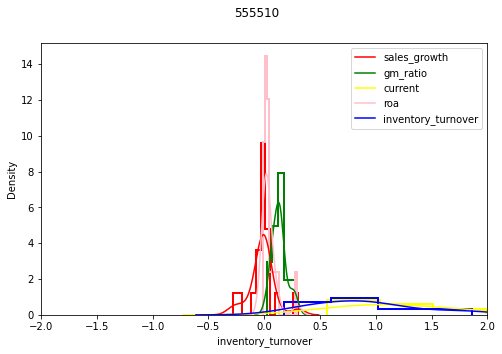

In [ ]:
warnings.filterwarnings(action='ignore') 

# 전체 데이터의 분포

plt.figure(figsize=(15,5))
plt.suptitle('All')
plt.subplot(111)
graph = graph_df
plt.subplot(151)
sns.distplot(graph['sales_growth'], color = 'red')
plt.xlim(-3,3)
plt.subplot(152)
sns.distplot(graph['gm_ratio'], color = 'red')
plt.xlim(-2,2)
plt.subplot(153)
sns.distplot(graph['current'], color = 'red')
plt.xlim(-1,9)
plt.subplot(154)
sns.distplot(graph['roa'], color = 'red')
plt.xlim(-1,1)
plt.subplot(155)
sns.distplot(graph['inventory_turnover'], color = 'red')
plt.xlim(0,5)
plt.show()
print('')

# 전체 데이터 분포 한번에 보기

plt.figure(figsize=(8,5))
plt.suptitle('All')
sns.distplot(graph['sales_growth'], hist = True, color = 'red', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(graph['gm_ratio'], hist = True, color = 'green', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(graph['current'], hist = True, color = 'yellow', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(graph['roa'], hist = True, color = 'pink', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(graph['inventory_turnover'], hist = True, color = 'blue', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
plt.xlim(-2,2)
plt.legend(['sales_growth','gm_ratio','current','roa','inventory_turnover'])
plt.show()


# k_code 별로 sales_growth, gm_ratio, current, roa의 분포도를 보고 싶다.
# 단 k_code안에 20개 이상의 데이터가 존재해야 한다.
tmp = graph_df.groupby(['k_code']).count()
tmp = tmp[tmp['c_code'] >= 20]
k_codes = tmp.index.tolist()

for k_code in k_codes:
    plt.figure(figsize=(8,5))
    plt.suptitle(f'{k_code}')
    graph = graph_df[graph_df['k_code'] == k_code]
    sns.distplot(graph['sales_growth'], hist = True, color = 'red', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
    sns.distplot(graph['gm_ratio'], hist = True, color = 'green', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
    sns.distplot(graph['current'], hist = True, color = 'yellow', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
    sns.distplot(graph['roa'], hist = True, color = 'pink', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
    sns.distplot(graph['inventory_turnover'], hist = True, color = 'blue', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
    plt.xlim(-2,2)
    plt.legend(['sales_growth','gm_ratio','current','roa','inventory_turnover'])
    plt.show()

warnings.filterwarnings(action='default')

#### 확인 결과
* sales_growth : 중심이 있는 정규분포
* gm_ratio : 0 아래의 값은 거의 없으며, 0이 가장 많고 높아질수록 데이터가 줄어드는 구조, 단 사업구조상 매출원가가 없는 경우 1이 되는 경우가 있음.
* current : 0을 시작으로 하며, 높아질수록 데이터가 줄어드는 구조
* roa : 중심이 있는 정규분포
* inventory_turnover : 중심이 있는 정규분포

업종별로 차이가 조금은 있으나, 크게 느껴지지는 않음.
gm_ratio만 업종별 차이가 심한 편
따라서 다른 지표는 업종별로 나누는 것은 의미가 거의없다.

### 데이터 정규화 및 불필요 데이터 제거

사용할 지표

1. sales_growth : 점수로 활용
2. roa : 점수로 활용 
3. inventory_turnover : 점수로 활용
4. current : 유동비율 => 높을수록 좋다 ( 평균 이하는 투자에서 제외 )

In [122]:
stats = graph_df.describe()
stats

,sales_growth,gm_ratio,current,roa,inventory_turnover
count,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000
mean,0.128544,0.284321,2.968165,0.000265,0.853245
std,0.548876,0.256497,4.811527,0.142312,0.532060
min,-0.848800,-1.666700,0.069600,-1.977600,0.004700
25%,-0.061100,0.120550,1.052200,-0.018925,0.503625
50%,0.042000,0.204500,1.633100,0.020200,0.751600
75%,0.180825,0.379575,2.970675,0.059625,1.094425
max,8.472500,1.000000,90.400000,0.352700,4.486300


In [123]:
# current가 중간값 이하인 데이터 제거
normalized_df = graph_df[graph_df['current'] >= stats['current']['25%']].copy()
normalized_df['score'] = 0
# 2 이상인 값은 2로 통일
def max_score(x):
    if x > 2:
        return 2
    else:
        return x

# 데이터 정규화 및 평균 이하 데이터 제거
scores = ['sales_growth','roa','inventory_turnover']
for score in scores:
    normalized_df[score] = (normalized_df[score] - stats[score]['mean']) / stats[score]['std']
    normalized_df = normalized_df[normalized_df[score] > 0]
    normalized_df[score] = normalized_df[score].apply(max_score)
    normalized_df['score'] += normalized_df[score]

normalized_df = normalized_df.set_index('c_code')
normalized_df.sort_values(by = 'score', ascending=False)

,sales_growth,gm_ratio,current,roa,inventory_turnover,k_code,score
c_code,,,,,,,
337930,2.000000,0.6069,2.8018,2.000000,2.000000,252520,6.000000
032500,2.000000,0.3191,1.7243,2.000000,2.000000,454520,6.000000
347770,2.000000,0.3095,1.7521,2.000000,2.000000,454540,6.000000
352820,1.493337,0.3432,1.6879,1.787871,2.000000,505020,5.281208
138080,2.000000,0.4156,3.2103,2.000000,1.183804,454520,5.183804
...,...,...,...,...,...,...,...
002140,0.158062,0.1678,1.1492,0.155539,0.118699,303020,0.432300
017040,0.078080,0.1130,1.9313,0.321372,0.003487,202010,0.402939
010620,0.213994,0.0638,1.7420,0.123918,0.040701,202010,0.378613


## 날짜별 PBR 데이터 추출

In [124]:
end_date = dt.datetime.strptime(date, '%Y-%m-%d') + dt.timedelta(days=364)
end_date = dt.datetime.strftime(end_date, '%Y-%m-%d')

In [125]:
def pbr_data_extract(c_code, s_date = date, e_date = end_date):
    tmp_index = db_index.pop(0)
    db = db_list_aws[tmp_index]
    try:
        sql = f"""
                select tmp_ftbl.c_code, tmp_prtbl.p_date, tmp_prtbl.price / tmp_ftbl.bps as pbr
                    from
                        (select c_code, f_date, bps from ftbl) as tmp_ftbl,
                        (select c_code, p_date, price from prtbl) as tmp_prtbl
                    where 
                        tmp_ftbl.c_code = {c_code} and
                        tmp_prtbl.c_code = {c_code} and
                        tmp_prtbl.p_date >= tmp_ftbl.f_date and
                        tmp_prtbl.p_date >= '{s_date}' and
                        tmp_prtbl.p_date <= '{e_date}'
                    group by p_date

            """
        df = pd.read_sql(sql, db)
    except:
        print(f'Error : {code}')    
    finally:
        progress[tmp_index] = progress[tmp_index] + 1
        db_index.append(tmp_index)
        my_pbar(sum(progress),len_code.value)

    return df

code_list = normalized_df.index.tolist()
len_code = manager.Value(int, len(code_list))
pool = Pool(num_cores) # process 만들기
 
start_time = dt.datetime.now()
prices = list(pool.map(pbr_data_extract, code_list))
my_pbar(100,100)
progress = manager.list([0 for x in range(num_cores)])
print('\n총 걸린시간 : %s' %(dt.datetime.now() - start_time))
pool.close()
pool.join()

 Percent: [<▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮>] 100.0%
총 걸린시간 : 0:01:51.365197


In [126]:
# 날짜 만들기 (삼성전자 기준)
date_list = pd.read_sql(f"select p_date from prtbl where c_code = 005930 and p_date >= '{date}' and p_date <= '{end_date}'",db)

# 하나의 데이터프레임으로 정렬
df = pd.DataFrame(data = None, index = date_list['p_date'].tolist())

for data in prices:
    try:
        code = data['c_code'][0]
        tmp_df = data.drop(['c_code'],axis=1).set_index('p_date')
        tmp_df.columns = [code]
        try:
            tmp = df[code]
        except:
            df = pd.merge(df, tmp_df,left_index=True, right_index=True, how = 'left')
    except:
        pass

df.index = pd.to_datetime(df.index)
df

,001880,002140,002150,002290,002410,002600,002990,003010,003030,003230,003520,003850,004710,005390,005670,005850,005960,006050,006620,006980,007700,007820,008470,008770,009440,010620,010640,010960,011390,013700,013810,013890,017000,017040,018880,020120,020180,020710,021320,024890,...,244920,253450,256150,258790,260660,263600,263720,264660,267320,267790,270520,270870,272290,278650,282880,284740,290520,290550,290720,294870,298540,303030,306040,306200,307750,309930,317400,318020,320000,322000,322180,323230,332370,332570,335890,337930,340930,347770,348030,352820
2020-05-04,0.9249,0.9186,1.2306,0.6182,1.4455,0.7123,0.7957,0.5453,0.1268,3.4745,7.9672,2.4400,0.6364,0.7147,1.2591,0.3382,0.4910,1.7895,2.2895,0.6229,2.1100,2.0403,0.5173,3.8440,0.4856,0.5167,1.4398,0.6720,3.0272,1.0134,1.8379,5.7043,0.4288,0.9889,2.3139,6.7335,1.7817,1.2020,0.3631,0.7712,...,NaN,5.3618,3.3994,145.0000,2.7313,1.4841,7.5325,1.0933,33.7963,2.3108,2.6157,4.1513,2.1376,6.2626,8.3753,2.0970,NaN,2.5654,3.2075,0.4572,NaN,5.2166,9.7605,0.2054,6.6799,2.1239,1.3069,NaN,2.8846,0.6499,5.8957,1.7079,NaN,NaN,20.3486,NaN,NaN,NaN,NaN,NaN
2020-05-06,0.9353,0.9549,1.2522,0.6160,1.4950,0.7123,0.7887,0.5662,0.1265,3.5071,8.0492,2.5470,0.7082,0.7179,1.2779,0.3396,0.5008,1.7961,2.3629,0.6285,2.1002,2.0641,0.5226,3.9039,0.4945,0.5384,1.4635,0.6829,3.0877,1.0171,1.7897,5.9739,0.4275,1.0034,2.3139,6.8959,1.8379,1.2061,0.3637,0.8188,...,NaN,5.3827,3.5089,147.7273,2.8113,1.4919,8.8474,1.1156,33.7037,2.4924,2.7465,4.5203,2.1436,6.5640,8.4260,2.2296,NaN,2.6451,3.2926,0.4584,NaN,5.2731,9.6004,0.2041,6.6799,2.1239,1.3254,NaN,2.8704,0.6717,5.8503,1.7120,NaN,NaN,20.1468,NaN,NaN,NaN,NaN,NaN
2020-05-07,0.8836,0.9562,1.2791,0.6215,1.5198,0.7218,0.7878,0.5597,0.1257,3.6376,8.1230,2.5470,0.7241,0.7241,1.2570,0.3423,0.4997,1.7862,2.3696,0.6200,2.1393,2.2099,0.5173,3.7980,0.5015,0.5358,1.4740,0.6774,3.1382,1.0097,1.8299,5.8909,0.4262,1.0226,2.3061,6.9341,1.8379,1.1999,0.3649,0.8441,...,NaN,5.4526,3.5455,155.4545,2.8685,1.6325,8.5390,1.1379,33.9815,2.4823,2.8370,4.5480,2.1679,6.9993,8.7455,2.3170,NaN,2.7588,3.2146,0.4465,NaN,5.2448,9.9898,0.2028,6.6799,2.1239,1.3773,NaN,2.8704,0.6886,5.8730,1.7120,NaN,NaN,20.3486,NaN,NaN,NaN,NaN,NaN
2020-05-08,0.8713,1.0019,1.3021,0.6182,1.5173,0.7314,0.7957,0.5597,0.1305,3.7192,8.1967,2.5470,0.7717,0.7241,1.2404,0.3544,0.5032,1.7530,2.4497,0.6172,2.1490,2.2337,0.5244,3.7888,0.4996,0.5402,1.4950,0.6815,3.1886,1.0246,1.8218,5.7873,0.4301,1.0419,2.3244,6.9723,1.8459,1.2124,0.3667,0.8469,...,NaN,5.4666,3.6645,155.9091,2.8913,1.6169,8.6688,1.1810,35.0000,2.5631,2.8974,4.5849,2.3501,7.1668,8.7118,2.2868,NaN,2.8726,3.1365,0.4477,NaN,5.2072,10.4098,0.2177,6.6799,2.1239,1.4737,NaN,2.8704,0.7441,6.0771,1.7120,NaN,NaN,20.6514,NaN,NaN,NaN,NaN,NaN
2020-05-11,0.8816,0.9280,1.2724,0.6127,1.4703,0.7266,0.7749,0.5471,0.1327,3.6702,8.2787,2.5566,0.7548,0.6991,1.2237,0.3691,0.5061,1.6799,2.4564,0.5919,2.0611,2.2602,0.5214,3.6737,0.5046,0.5289,1.4714,0.6869,2.9868,1.0060,1.8406,5.7873,0.4176,0.9986,2.4030,6.8481,1.8218,1.2165,0.3649,0.8525,...,NaN,5.3688,3.6371,201.8182,2.8340,1.5739,8.9123,1.1632,34.1667,2.5530,2.9879,4.8985,2.2742,7.2338,9.0313,2.4405,NaN,3.0148,3.2075,0.4703,NaN,5.3578,10.0102,0.2290,6.6982,2.1239,1.4969,NaN,2.8775,0.7845,6.3492,1.7120,NaN,NaN,20.5505,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,1.4782,1.1416,1.3101,1.3434,2.0767,0.8843,1.0107,0.9833,0.3313,2.9460,10.8361,5.0571,1.1681,1.1486,1.6010,0.8285,0.7824,1.9223,3.9645,0.7129,3.4970,2.2178,0.8759,3.8947,0.6014,1.2699,1.9469,0.6978,2.6538,2.0343,5.1739,6.4873,0.9368,1.2729,4.4156,16.1891,3.2263,1.8289,0.7081,1.5564,...,3.0127,7.0395,7.7766,363.6364,3.0539,1.7067,15.9253,2.1122,90.9259,1.9354,9.22

## score & pbr 데이터 그래프로 확인

### 3D 그래프

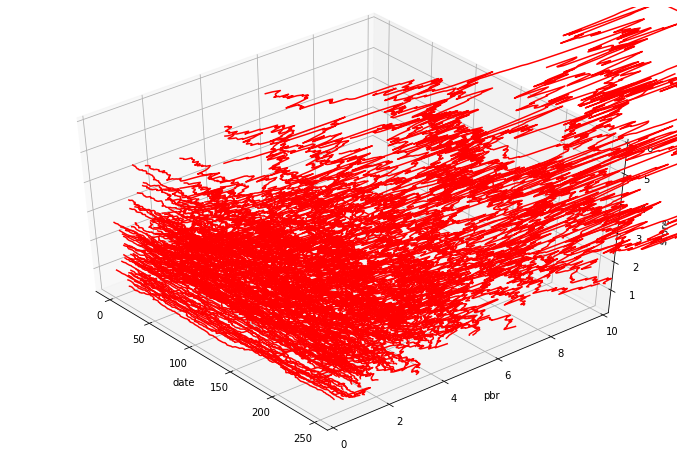

In [ ]:
# 3D 그래프 그리기

fig = plt.figure(1, figsize = (12,8))
fig_graph = fig.add_subplot(111, projection = '3d')
x = df.index.tolist()
x = [num for num,i in enumerate(x)]
length = len(x)
for code in df.columns.tolist():
    y = df[code]
    z = [normalized_df['score'][code]] * length

    fig_graph.plot(x,y,z, 'r')

fig_graph.set_xlabel('date')
fig_graph.set_ylabel('pbr')
fig_graph.set_zlabel('score')
fig_graph.set_ylim([0,10])

fig_graph.view_init(45,320)
plt.show()

### 2차원 그래프(alpha 이용)

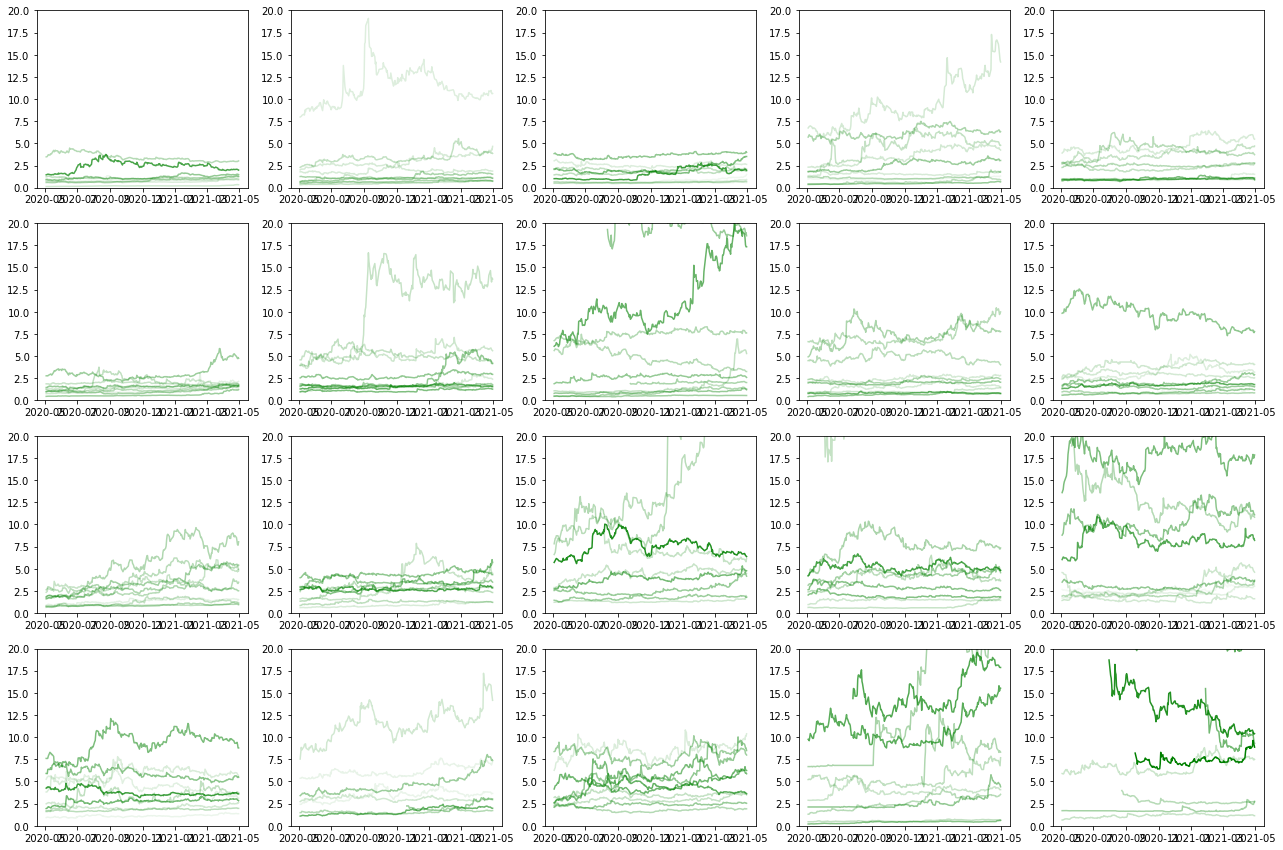

In [ ]:
slicing = int(len(df.columns) / 20)
columns = df.columns.tolist()

plt.figure(figsize=(22,15)) # figsize : 캔버스의 크기 설정

x = df.index.tolist()
for i in range(0,20):
    plt.subplot(4,5,i+1)
    for code in columns[slicing*i:slicing*(i+1)]:
        y = df[code]
        plt.plot(x,y, c = 'g', alpha = normalized_df['score'][code]/6)
    plt.ylim(0,20)

plt.show()

### 2차원 그래프 (custom colorbar 이용)

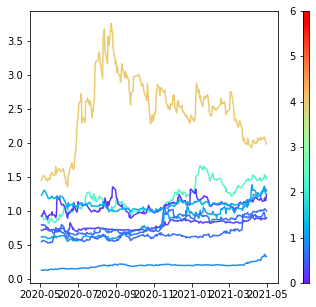

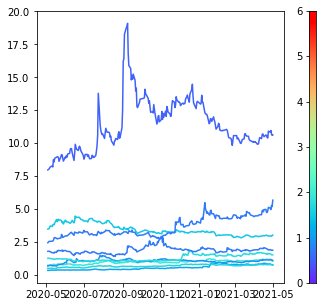

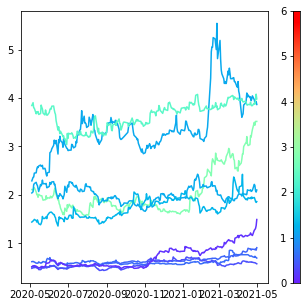

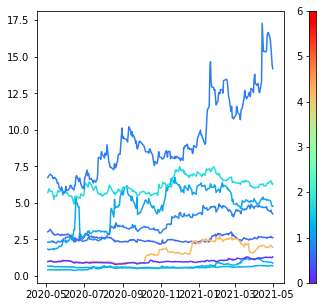

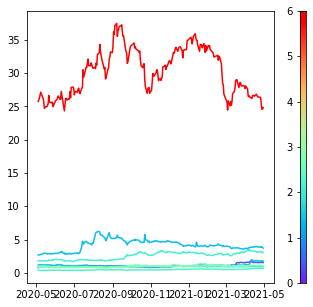

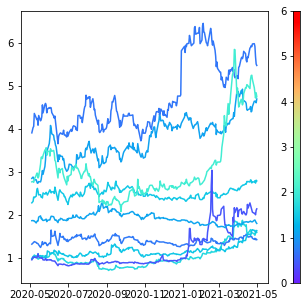

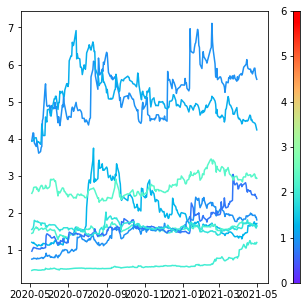

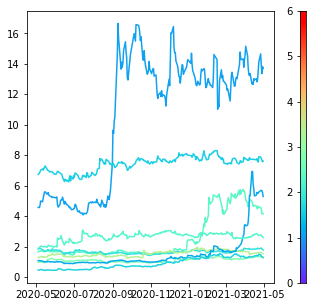

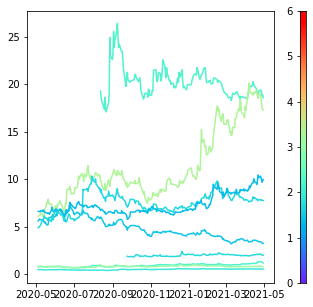

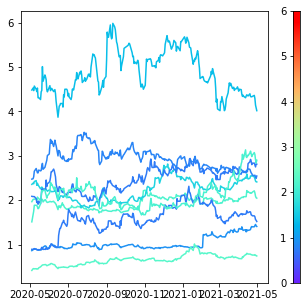

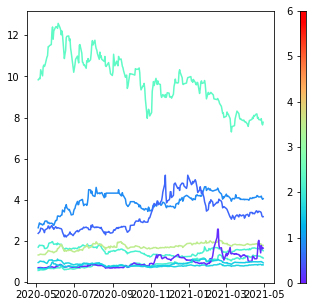

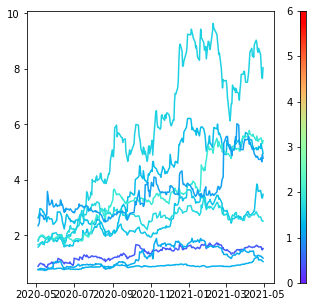

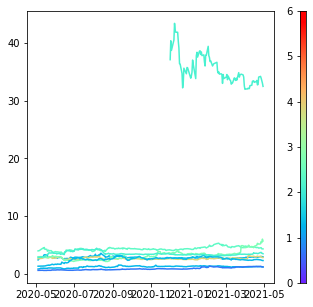

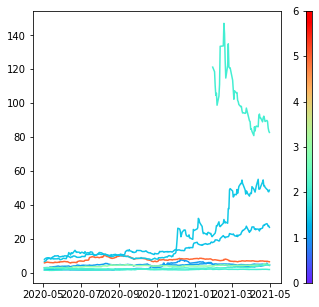

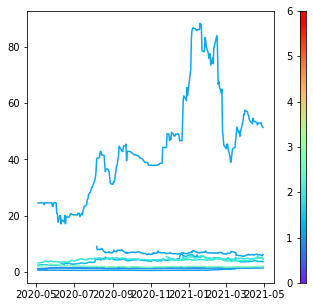

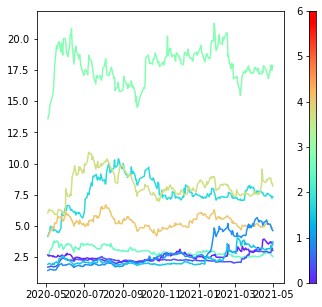

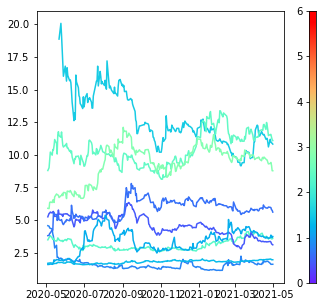

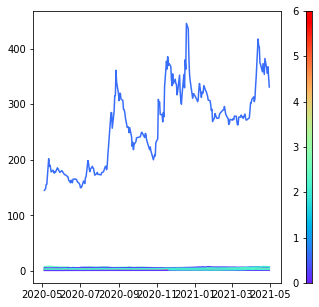

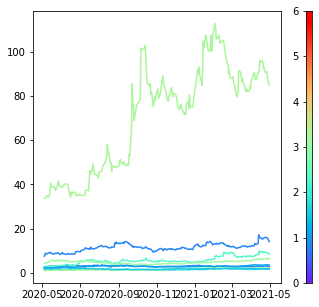

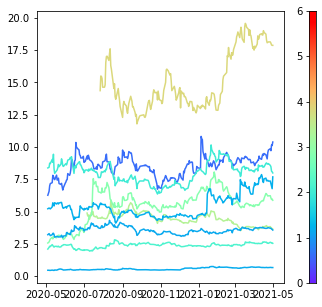

In [142]:
num_slice = 20
columns = df.columns.tolist()
x = df.index.tolist()

slicing = int(len(df.columns) / num_slice)

for i in range(0,num_slice):
    ax = custom_colorbargraph(0,6)
    for code in columns[slicing*i:slicing*(i+1)]:
        y = df[code]
        plt.plot(x,y, c = color_find(0,6,normalized_df['score'][code]))
    plt.show()

생각보다 score 와 pbr간의 상관관계를 찾기 쉽지 않다.

WICS를 활용하여 pbr분류 해보기.!

## WICS 기준 PBR 분류

In [ ]:
end_date = dt.datetime.strptime(date, '%Y-%m-%d') + dt.timedelta(days=364)
end_date = dt.datetime.strftime(end_date, '%Y-%m-%d')

def pbr_kcode_data_extract(c_code, s_date = date, e_date = end_date):
    df = pd.DataFrame()
    tmp_index = db_index.pop(0)
    db = db_list_aws[tmp_index]
    try:
        sql = f"""
                select tmp_ftbl.c_code, tmp_prtbl.p_date, tmp_prtbl.price / tmp_ftbl.bps as pbr, tmp_kcodetbl.k_code
                    from
                        (select c_code, f_date, bps from ftbl) as tmp_ftbl,
                        (select c_code, p_date, price from prtbl) as tmp_prtbl,
                        (select c_code, concat(c_kindlarge,c_kindsmall) as k_code from comtbl) as tmp_kcodetbl
                    where 
                        tmp_ftbl.c_code = {c_code} and
                        tmp_prtbl.c_code = {c_code} and
                        tmp_kcodetbl.c_code = {c_code} and
                        tmp_prtbl.p_date >= tmp_ftbl.f_date and
                        tmp_prtbl.p_date >= '{s_date}' and
                        tmp_prtbl.p_date <= '{e_date}'
                    group by p_date

            """
        df = pd.read_sql(sql, db)
    except:
        print(f'Error : {code}')    
    finally:
        progress[tmp_index] = progress[tmp_index] + 1
        db_index.append(tmp_index)
        my_pbar(sum(progress),len_code.value)

    return df

code_list = pd.read_sql('select distinct c_code from comtbl',db)['c_code'].tolist()
len_code = manager.Value(int, len(code_list))
pool = Pool(num_cores) # process 만들기
 
start_time = dt.datetime.now()
k_code_prices = list(pool.map(pbr_kcode_data_extract, code_list))
k_code_prices = [x for x in k_code_prices if len(x) > 0]
my_pbar(100,100)
progress = manager.list([0 for x in range(num_cores)])
print('\n총 걸린시간 : %s' %(dt.datetime.now() - start_time))
pool.close()
pool.join()


 Percent: [<▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮>] 100.0%
총 걸린시간 : 0:20:11.079519


In [ ]:
# 알고리즘 적으로 비효율적이지만, 데이터가 많지 않으므로 효과가 있는 모델을 만들어 내기 위해 빠르게 실험만 해보기 위한 코드

k_code_list = list(set([x['k_code'][0] for x in k_code_prices]))

# k_code별로 분류하기
df_k_code = []

date_list = pd.read_sql(f"select p_date from prtbl where c_code = 005930 and p_date >= '{date}' and p_date <= '{end_date}'",db)

for k_code in k_code_list:
    df = pd.DataFrame(data = None, index = date_list['p_date'].tolist())
    for data in k_code_prices:
        if data['k_code'][0] == k_code:
            code = data['c_code'][0]
            tmp_df = data.drop(['c_code', 'k_code'],axis=1).set_index('p_date')
            tmp_df.columns = [code]
            df = pd.merge(df, tmp_df,left_index=True, right_index=True, how = 'left')
    df_k_code.append(df)

# k_code 안에 속한 회사가 20개 미만인 것은 제외
for index in range(len(df_k_code)-1,-1,-1):
    if len(df_k_code[index].T) < 20:
        del df_k_code[index]
        del k_code_list[index]

In [ ]:
# 다시 데이터베이스 작업하는 것을 방지하기 위해 데이터 저장
import pickle

with open('/content/gdrive/MyDrive/파이썬 투자/파이썬 퀀트/df_k_code.pkl','wb') as f:
    pickle.dump(df_k_code,f)

with open('/content/gdrive/MyDrive/파이썬 투자/파이썬 퀀트/k_code_list.pkl','wb') as f:
    pickle.dump(k_code_list,f)

In [ ]:
# 데이터 다시 불러오기
with open('/content/gdrive/MyDrive/파이썬 투자/파이썬 퀀트/df_k_code.pkl','rb') as f:
    df_k_code = pickle.load(f)

with open('/content/gdrive/MyDrive/파이썬 투자/파이썬 퀀트/k_code_list.pkl','rb') as f:
    k_code_list = pickle.load(f)

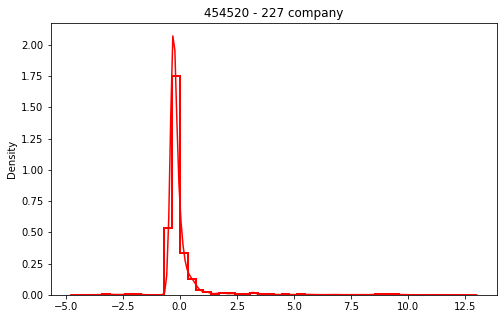

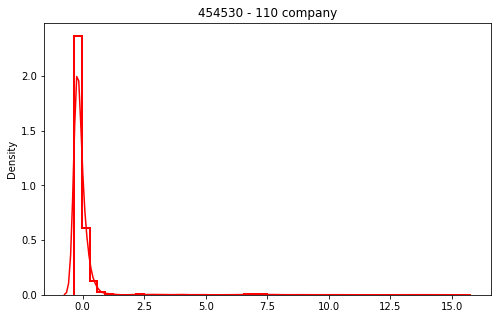

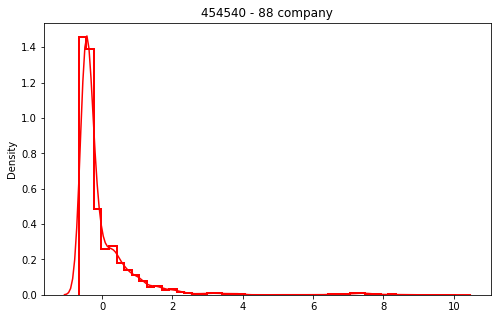

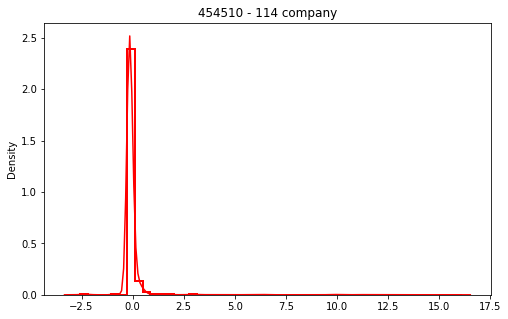

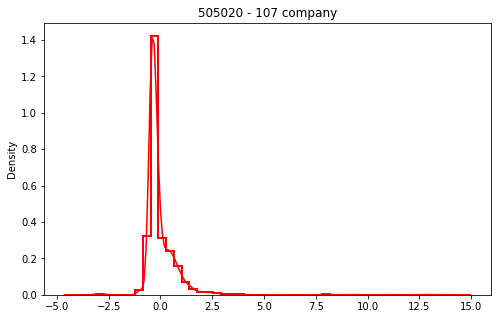

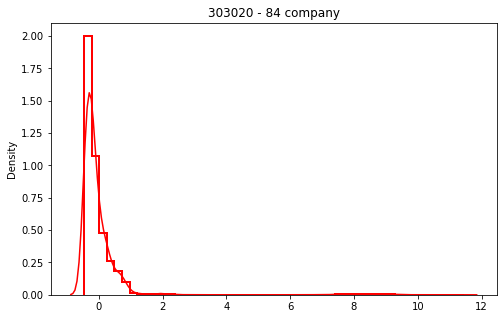

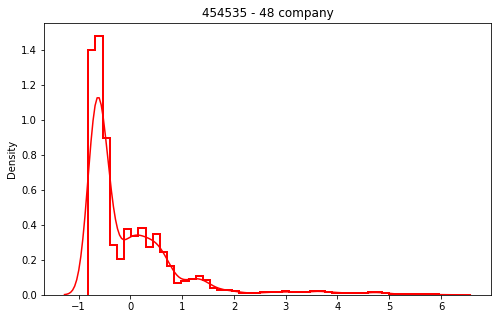

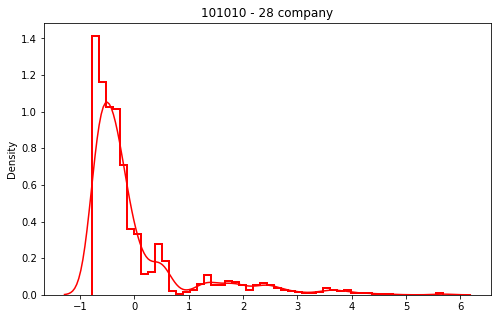

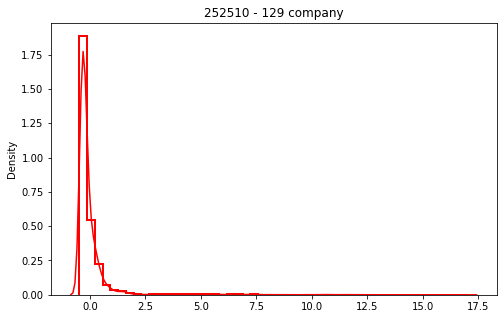

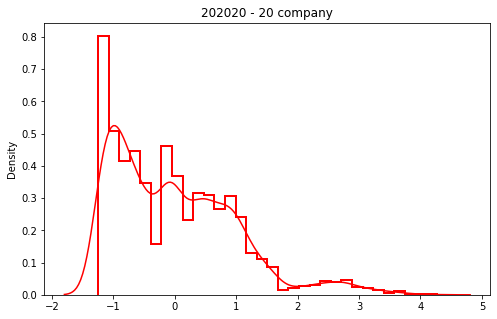

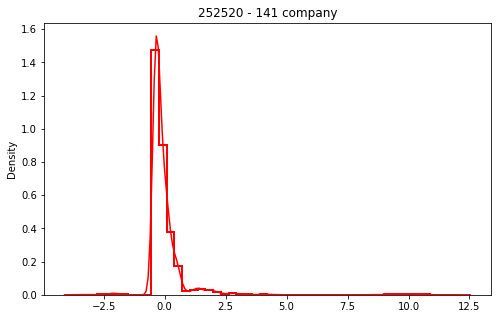

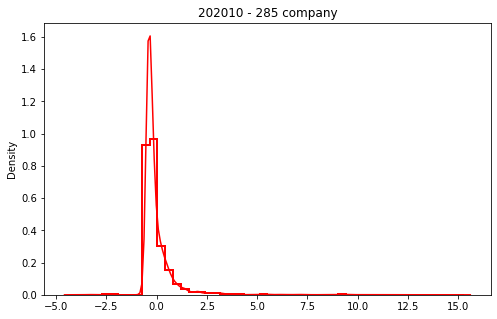

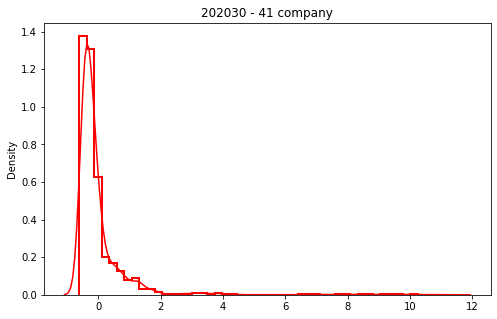

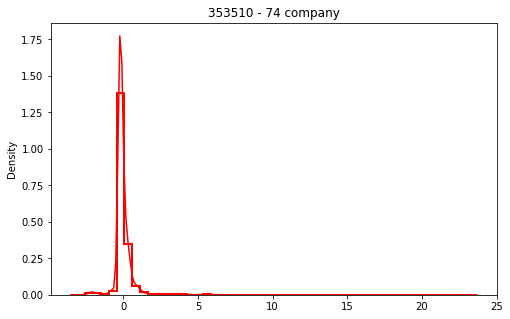

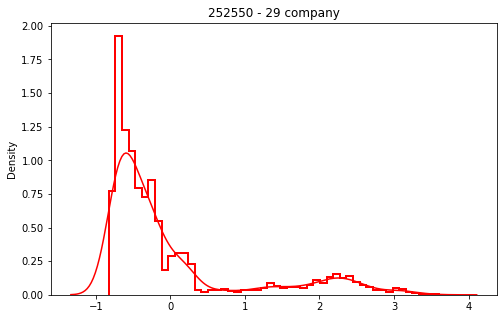

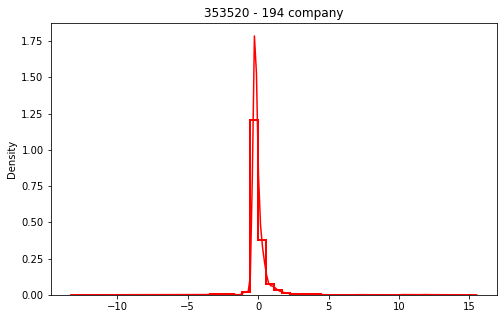

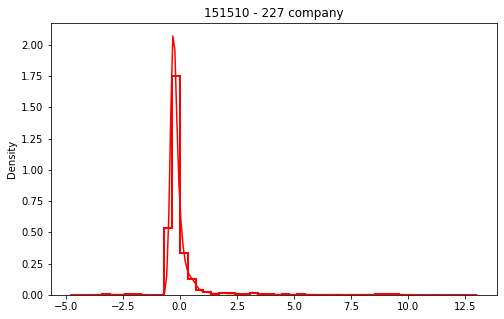

In [ ]:
warnings.filterwarnings(action='ignore') 

for index, data in enumerate(df_k_code):
    datas = np.ravel(data).tolist()
    datas = [x for x in datas if np.isnan(x) == False]
    length = len(data.T)
    mean = np.mean(datas)
    std = np.std(datas)
    datas = (datas - mean) / std
    plt.figure(figsize=(8,5))
    ax = sns.distplot(datas, hist = True, color = 'red', hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
    ax.set_title(f'{k_code_list[index]} - {length} company')
    plt.show()

warnings.filterwarnings(action='default')

https://ichi.pro/ko/model-e-bijeong-gyu-olyu-bunpogaiss-eul-ttae-suhaeng-hal-jag-eob-272419141863263

* 통계적 정규화 방법

https://frhyme.github.io/python-lib/matplotlib_extracting_color_from_cmap/

colorbar 확인

# 데이터 추출용

In [ ]:
date = '2020-05-01'
sql = f"""
with f_rank_cte as
(select c_code, f_date, sales, gm, ni, asset, ca, cl, issued_shares, bps, eps,
    RANK() OVER ( 
        partition by c_code 
        order by f_date desc) Ranking
    from ftbl 
    where f_date <= '{date}'
            ),

k_code_cte as
(select
    c_code,
    concat(c_kindlarge,c_kindsmall) as k_code
    from comtbl
),

f_score_cte as
(select
    first_year_cte.c_code as c_code,
    first_year_cte.sales / second_year_cte.sales - 1 as sales_growth,
    first_year_cte.gm / first_year_cte.sales as gm_ratio,
    first_year_cte.ca / first_year_cte.cl as current,
    first_year_cte.ni / ( ( first_year_cte.asset + second_year_cte.asset ) / 2 ) as roa,
    first_year_cte.sales / ( ( first_year_cte.asset + second_year_cte.asset ) / 2 ) as inventory_turnover,
    k_code_cte.k_code as k_code
    from
        (select * from f_rank_cte where Ranking = 1) as first_year_cte,
        (select * from f_rank_cte where Ranking = 2) as second_year_cte,
        (select * from k_code_cte) as k_code_cte
    where
        first_year_cte.c_code = second_year_cte.c_code and
        first_year_cte.c_code = k_code_cte.c_code
),

statistics_rank_cte as
(select
    c_code,
    Rank() over (partition by k_code order by sales_growth) as sales_growth_rank,
    Rank() over (partition by k_code order by gm_ratio) as gm_ratio_rank,
    Rank() over (partition by k_code order by current) as current_rank,
    Rank() over (partition by k_code order by roa) as roa_rank,
    Rank() over (partition by k_code order by inventory_turnover) as inventory_turnover_rank,
    k_code
    from f_score_cte
),

high_low_cnt_cte as
(select
    k_code,
    cast(Floor(count(*) * 0.8) as signed integer) as high,
    cast(Floor(count(*) * 0.2) as signed integer) as low
    from f_score_cte
    group by k_code
),

high_sales_cte as
(select
    high_cte.k_code as k_code,
    high_cte.goal_value as goal_value
    from
    (select
        f_score_cte.c_code as c_code,
        f_score_cte.sales_growth as goal_value,
        f_score_cte.k_code as k_code
        from
        (select 
            * 
            from statistics_rank_cte
            where (k_code, sales_growth_rank) in 
                (select k_code, high from high_low_cnt_cte where high >= 10)
        ) as tmp_high,
        (select * from f_score_cte) as f_score_cte
        where
            tmp_high.c_code = f_score_cte.c_code
    ) as high_cte
),

high_gm_cte as
(select
    high_cte.k_code as k_code,
    high_cte.goal_value as goal_value
    from
    (select
        f_score_cte.c_code as c_code,
        f_score_cte.gm_ratio as goal_value,
        f_score_cte.k_code as k_code
        from
        (select 
            * 
            from statistics_rank_cte
            where (k_code, gm_ratio_rank) in 
                (select k_code, high from high_low_cnt_cte where high >= 10)
        ) as tmp_high,
        (select * from f_score_cte) as f_score_cte
        where
            tmp_high.c_code = f_score_cte.c_code
    ) as high_cte
),

high_current_cte as
(select
    high_cte.k_code as k_code,
    high_cte.goal_value as goal_value
    from
    (select
        f_score_cte.c_code as c_code,
        f_score_cte.current as goal_value,
        f_score_cte.k_code as k_code
        from
        (select 
            * 
            from statistics_rank_cte
            where (k_code, current_rank) in 
                (select k_code, high from high_low_cnt_cte where high >= 10)
        ) as tmp_high,
        (select * from f_score_cte) as f_score_cte
        where
            tmp_high.c_code = f_score_cte.c_code
    ) as high_cte
),

high_roa_cte as
(select
    high_cte.k_code as k_code,
    high_cte.goal_value as goal_value
    from
    (select
        f_score_cte.c_code as c_code,
        f_score_cte.roa as goal_value,
        f_score_cte.k_code as k_code
        from
        (select 
            * 
            from statistics_rank_cte
            where (k_code, roa_rank) in 
                (select k_code, high from high_low_cnt_cte where high >= 10)
        ) as tmp_high,
        (select * from f_score_cte) as f_score_cte
        where
            tmp_high.c_code = f_score_cte.c_code
    ) as high_cte
),

high_it_cte as
(select
    high_cte.k_code as k_code,
    high_cte.goal_value as goal_value
    from
    (select
        f_score_cte.c_code as c_code,
        f_score_cte.inventory_turnover as goal_value,
        f_score_cte.k_code as k_code
        from
        (select 
            * 
            from statistics_rank_cte
            where (k_code, inventory_turnover_rank) in 
                (select k_code, high from high_low_cnt_cte where high >= 10)
        ) as tmp_high,
        (select * from f_score_cte) as f_score_cte
        where
            tmp_high.c_code = f_score_cte.c_code
    ) as high_cte
),

low_sales_cte as
(select
    low_cte.k_code as k_code,
    low_cte.goal_value as goal_value
    from
    (select
        f_score_cte.c_code as c_code,
        f_score_cte.sales_growth as goal_value,
        f_score_cte.k_code as k_code
        from
        (select 
            * 
            from statistics_rank_cte
            where (k_code, sales_growth_rank) in 
                (select k_code, low from high_low_cnt_cte where high >= 10)
        ) as tmp_low,
        (select * from f_score_cte) as f_score_cte
        where
            tmp_low.c_code = f_score_cte.c_code
    ) as low_cte
),

low_gm_cte as
(select
    low_cte.k_code as k_code,
    low_cte.goal_value as goal_value
    from
    (select
        f_score_cte.c_code as c_code,
        f_score_cte.gm_ratio as goal_value,
        f_score_cte.k_code as k_code
        from
        (select 
            * 
            from statistics_rank_cte
            where (k_code, gm_ratio_rank) in 
                (select k_code, low from high_low_cnt_cte where high >= 10)
        ) as tmp_low,
        (select * from f_score_cte) as f_score_cte
        where
            tmp_low.c_code = f_score_cte.c_code
    ) as low_cte
),

low_current_cte as
(select
    low_cte.k_code as k_code,
    low_cte.goal_value as goal_value
    from
    (select
        f_score_cte.c_code as c_code,
        f_score_cte.current as goal_value,
        f_score_cte.k_code as k_code
        from
        (select 
            * 
            from statistics_rank_cte
            where (k_code, current_rank) in 
                (select k_code, low from high_low_cnt_cte where high >= 10)
        ) as tmp_low,
        (select * from f_score_cte) as f_score_cte
        where
            tmp_low.c_code = f_score_cte.c_code
    ) as low_cte
),

low_roa_cte as
(select
    low_cte.k_code as k_code,
    low_cte.goal_value as goal_value
    from
    (select
        f_score_cte.c_code as c_code,
        f_score_cte.roa as goal_value,
        f_score_cte.k_code as k_code
        from
        (select 
            * 
            from statistics_rank_cte
            where (k_code, roa_rank) in 
                (select k_code, low from high_low_cnt_cte where high >= 10)
        ) as tmp_low,
        (select * from f_score_cte) as f_score_cte
        where
            tmp_low.c_code = f_score_cte.c_code
    ) as low_cte
),

low_it_cte as
(select
    low_cte.k_code as k_code,
    low_cte.goal_value as goal_value
    from
    (select
        f_score_cte.c_code as c_code,
        f_score_cte.inventory_turnover as goal_value,
        f_score_cte.k_code as k_code
        from
        (select 
            * 
            from statistics_rank_cte
            where (k_code, inventory_turnover_rank) in 
                (select k_code, low from high_low_cnt_cte where high >= 10)
        ) as tmp_low,
        (select * from f_score_cte) as f_score_cte
        where
            tmp_low.c_code = f_score_cte.c_code
    ) as low_cte
),

asdfg_cte as
(
select 
    f_score_cte.c_code as c_code,
    f_score_cte.k_code as k_code_f,
    high_sales_cte.k_code as k_code_h,
    (f_score_cte.sales_growth - low_sales_cte.goal_value) / high_sales_cte.goal_value as sales_growth
    from
    (select * from f_score_cte) as f_score_cte,
    (select * from high_sales_cte) as high_sales_cte,
    (select * from low_sales_cte) as low_sales_cte
    where 
        f_score_cte.k_code = high_sales_cte.k_code and
        f_score_cte.k_code = low_sales_cte.k_code
)

select * from asdfg_cte
"""
pd.read_sql(sql,db)

KeyboardInterrupt: ignored

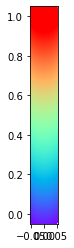

In [ ]:
y = np.linspace(0.0, 1.0, 256).tolist()

## PBR or PER 추출